In [1]:
import ipywidgets as widgets

display(widgets.Checkbox(value=True, description="乱数の種", indent=False))

Checkbox(value=True, description='乱数の種', indent=False)

In [2]:
display(widgets.IntText())

IntText(value=0)

In [3]:
from marubatsu import Marubatsu_GUI

def __init__(self, mb, ai_dict=None, seed=None, size=3):   
    # ai_dict が None の場合は、空の list で置き換える
    if ai_dict is None:
        ai_dict = {}

    self.mb = mb
    self.ai_dict = ai_dict
    self.seed=seed
    self.size = size

    # ai_dict が None の場合は、空の list で置き換える
    if ai_dict is None:
        self.ai_dict = {}

    # %matplotlib widget のマジックコマンドを実行する
    get_ipython().run_line_magic('matplotlib', 'widget')
    
    self.create_widgets()
    self.create_event_handler()
    self.display_widgets() 

Marubatsu_GUI.__init__ = __init__

In [4]:
from marubatsu import Marubatsu

def play(self, ai, ai_dict=None, params=None, verbose=True, seed=None, gui=False, size=3):   
    # params が None の場合のデフォルト値を設定する
    if params is None:
        params = [{}, {}]
        
    # 一部の仮引数をインスタンスの属性に代入する
    self.ai = ai
    self.params = params
    self.verbose = verbose
    self.gui = gui
    
    # seed が None でない場合は、seed を乱数の種として設定する
    if seed is not None:
        random.seed(seed)

    # gui が True の場合に、GUI の処理を行う Marubatsu_GUI のインスタンスを作成する
    if gui:
        mb_gui = Marubatsu_GUI(self, ai_dict=ai_dict, seed=seed, size=size)  
    else:
        mb_gui = None
        
    self.restart()
    return self.play_loop(mb_gui)

Marubatsu.play = play

In [5]:
def create_widgets(self):
    # 乱数の種の Checkbox と IntText を作成する
    self.checkbox = widgets.Checkbox(value=self.seed is not None, description="乱数の種",
                                     indent=False, layout=widgets.Layout(width="100px"))
    self.inttext = widgets.IntText(value=0 if self.seed is None else self.seed,
                                   layout=widgets.Layout(width="100px"))   
    
    # AI を選択する Dropdown を作成する
    self.create_dropdown()
    # 変更、リセット、待ったボタンを作成する
    self.change_button = self.create_button("変更", 50)
    self.reset_button = self.create_button("リセット", 80)
    self.undo_button = self.create_button("待った", 60)    
    
    # リプレイのボタンとスライダーを作成する
    self.first_button = self.create_button("<<", 50)
    self.prev_button = self.create_button("<", 50)
    self.next_button = self.create_button(">", 50)
    self.last_button = self.create_button(">>", 50)     
    self.slider = widgets.IntSlider(layout=widgets.Layout(width="200px"))
    # ゲーム盤の画像を表す figure を作成する
    self.create_figure()       
    
Marubatsu_GUI.create_widgets = create_widgets

In [6]:
def display_widgets(self):
    # 乱数の種のウィジェットを横に配置した HBox を作成する
    hbox1 = widgets.HBox([self.checkbox, self.inttext])
    # 〇 と × の dropdown とボタンを横に配置した HBox を作成する
    hbox2 = widgets.HBox([self.dropdown_list[0], self.dropdown_list[1], self.change_button, self.reset_button, self.undo_button])
    # リプレイ機能のボタンを横に配置した HBox を作成する
    hbox3 = widgets.HBox([self.first_button, self.prev_button, self.next_button, self.last_button, self.slider]) 
    # hbox1 ~ hbox3 を縦に配置した VBox を作成し、表示する
    display(widgets.VBox([hbox1, hbox2, hbox3])) 
    
Marubatsu_GUI.display_widgets = display_widgets

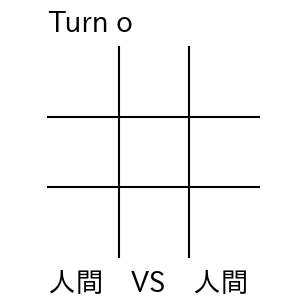

In [7]:
from util import gui_play

gui_play()


In [8]:
import ai as ai_module
import random

def gui_play(ai=None, ai_dict=None, seed=None):
    # ai が None の場合は、人間どうしの対戦を行う
    if ai is None:
        ai = [None, None]
    # ai_dict が None の場合は、ai1s ~ ai14s の Dropdown を作成するためのデータを計算する
    if ai_dict is None:
        ai_dict = { "人間": "人間"}
        for i in range(1, 15):
            ai_name = f"ai{i}s"  
            ai_dict[ai_name] = getattr(ai_module, ai_name)
    
    mb = Marubatsu()
    mb.play(ai=ai, ai_dict=ai_dict, seed=seed, gui=True)

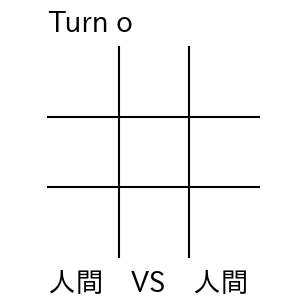

In [9]:
gui_play(seed=123)

In [10]:
def create_event_handler(self):
    # 変更ボタンのイベントハンドラを定義する
    def on_change_button_clicked(b):
        for i in range(2):
            self.mb.ai[i] = None if self.dropdown_list[i].value == "人間" else self.dropdown_list[i].value
        self.mb.play_loop(self)

    # リセットボタンのイベントハンドラを定義する
    def on_reset_button_clicked(b=None):
        # 乱数の種のチェックボックスが ON の場合に、乱数の種の処理を行う
        if self.checkbox.value:
            random.seed(self.inttext.value)
        self.mb.restart()
        on_change_button_clicked(b)

    # 待ったボタンのイベントハンドラを定義する
    def on_undo_button_clicked(b=None):
        if self.mb.move_count >= 2 and self.mb.move_count == len(self.mb.records) - 1:
            self.mb.move_count -= 2
            self.mb.records = self.mb.records[0:self.mb.move_count+1]
            self.mb.change_step(self.mb.move_count)
            self.draw_board()
        
    # イベントハンドラをボタンに結びつける
    self.change_button.on_click(on_change_button_clicked)
    self.reset_button.on_click(on_reset_button_clicked)   
    self.undo_button.on_click(on_undo_button_clicked)   
    
    # step 手目の局面に移動する
    def change_step(step):
        self.mb.change_step(step)
        # 描画を更新する
        self.draw_board()        

    def on_first_button_clicked(b=None):
        change_step(0)

    def on_prev_button_clicked(b=None):
        change_step(self.mb.move_count - 1)

    def on_next_button_clicked(b=None):
        change_step(self.mb.move_count + 1)
        
    def on_last_button_clicked(b=None):
        change_step(len(self.mb.records) - 1)

    def on_slider_changed(changed):
        if self.mb.move_count != changed["new"]:
            change_step(changed["new"])
            
    self.first_button.on_click(on_first_button_clicked)
    self.prev_button.on_click(on_prev_button_clicked)
    self.next_button.on_click(on_next_button_clicked)
    self.last_button.on_click(on_last_button_clicked)
    self.slider.observe(on_slider_changed, names="value")
    
    # ゲーム盤の上でマウスを押した場合のイベントハンドラ
    def on_mouse_down(event):
        # Axes の上でマウスを押していた場合のみ処理を行う
        if event.inaxes and self.mb.status == Marubatsu.PLAYING:
            x = math.floor(event.xdata)
            y = math.floor(event.ydata)
            self.mb.move(x, y)                
            # 次の手番の処理を行うメソッドを呼び出す
            self.mb.play_loop(self)

    # ゲーム盤を選択した状態でキーを押した場合のイベントハンドラ
    def on_key_press(event):
        keymap = {
            "up": on_first_button_clicked,
            "left": on_prev_button_clicked,
            "right": on_next_button_clicked,
            "down": on_last_button_clicked,
            "0": on_undo_button_clicked,
            "enter": on_reset_button_clicked,            
        }
        if event.key in keymap:
            keymap[event.key]()
        else:
            try:
                num = int(event.key) - 1
                event.inaxes = True
                event.xdata = num % 3
                event.ydata = 2 - (num // 3)
                on_mouse_down(event)
            except:
                pass
            
    # fig の画像イベントハンドラを結び付ける
    self.fig.canvas.mpl_connect("button_press_event", on_mouse_down)     
    self.fig.canvas.mpl_connect("key_press_event", on_key_press)  
    
Marubatsu_GUI.create_event_handler = create_event_handler

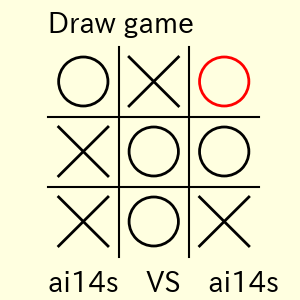

In [11]:
from ai import ai14s

gui_play(ai=[ai14s, ai14s], seed=123)

In [12]:
mb = Marubatsu()
mb.play(ai=[ai14s, ai14s], seed=123)

Turn o
...
...
...

Turn x
...
.O.
...

Turn o
...
.o.
X..

Turn x
O..
.o.
x..

Turn o
o..
.o.
x.X

Turn x
o..
.o.
xOx

Turn o
oX.
.o.
xox

Turn x
ox.
.oO
xox

Turn o
ox.
Xoo
xox

winner draw
oxO
xoo
xox



'draw'

In [13]:
def update_widgets_status(self):
    self.inttext.disabled = not self.checkbox.value
    self.set_button_status(self.undo_button, self.mb.move_count < 2 or self.mb.move_count != len(self.mb.records) - 1)
    self.set_button_status(self.first_button, self.mb.move_count <= 0)
    self.set_button_status(self.prev_button, self.mb.move_count <= 0)
    self.set_button_status(self.next_button, self.mb.move_count >= len(self.mb.records) - 1)
    self.set_button_status(self.last_button, self.mb.move_count >= len(self.mb.records) - 1)    
    # value 属性よりも先に max 属性に値を代入する必要がある点に注意！
    self.slider.max = len(self.mb.records) - 1
    self.slider.value = self.mb.move_count
    
Marubatsu_GUI.update_widgets_status = update_widgets_status

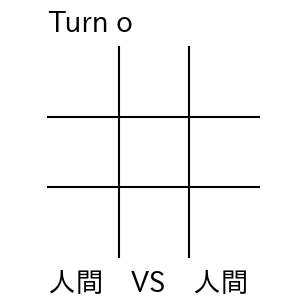

In [14]:
gui_play()

In [15]:
def create_event_handler(self):
    # 乱数の種のチェックボックスのイベントハンドラを定義する
    def on_checkbox_changed(changed):
        self.update_widgets_status()
        
    self.checkbox.observe(on_checkbox_changed, names="value")
    
    # 変更ボタンのイベントハンドラを定義する
    def on_change_button_clicked(b):
        for i in range(2):
            self.mb.ai[i] = None if self.dropdown_list[i].value == "人間" else self.dropdown_list[i].value
        self.mb.play_loop(self)

    # リセットボタンのイベントハンドラを定義する
    def on_reset_button_clicked(b=None):
        # 乱数の種のチェックボックスが ON の場合に、乱数の種の処理を行う
        if self.checkbox.value:
            random.seed(self.inttext.value)
        self.mb.restart()
        on_change_button_clicked(b)

    # 待ったボタンのイベントハンドラを定義する
    def on_undo_button_clicked(b=None):
        if self.mb.move_count >= 2 and self.mb.move_count == len(self.mb.records) - 1:
            self.mb.move_count -= 2
            self.mb.records = self.mb.records[0:self.mb.move_count+1]
            self.mb.change_step(self.mb.move_count)
            self.draw_board()
        
    # イベントハンドラをボタンに結びつける
    self.change_button.on_click(on_change_button_clicked)
    self.reset_button.on_click(on_reset_button_clicked)   
    self.undo_button.on_click(on_undo_button_clicked)   
    
    # step 手目の局面に移動する
    def change_step(step):
        self.mb.change_step(step)
        # 描画を更新する
        self.draw_board()        

    def on_first_button_clicked(b=None):
        change_step(0)

    def on_prev_button_clicked(b=None):
        change_step(self.mb.move_count - 1)

    def on_next_button_clicked(b=None):
        change_step(self.mb.move_count + 1)
        
    def on_last_button_clicked(b=None):
        change_step(len(self.mb.records) - 1)

    def on_slider_changed(changed):
        if self.mb.move_count != changed["new"]:
            change_step(changed["new"])
            
    self.first_button.on_click(on_first_button_clicked)
    self.prev_button.on_click(on_prev_button_clicked)
    self.next_button.on_click(on_next_button_clicked)
    self.last_button.on_click(on_last_button_clicked)
    self.slider.observe(on_slider_changed, names="value")
    
    # ゲーム盤の上でマウスを押した場合のイベントハンドラ
    def on_mouse_down(event):
        # Axes の上でマウスを押していた場合のみ処理を行う
        if event.inaxes and self.mb.status == Marubatsu.PLAYING:
            x = math.floor(event.xdata)
            y = math.floor(event.ydata)
            self.mb.move(x, y)                
            # 次の手番の処理を行うメソッドを呼び出す
            self.mb.play_loop(self)

    # ゲーム盤を選択した状態でキーを押した場合のイベントハンドラ
    def on_key_press(event):
        keymap = {
            "up": on_first_button_clicked,
            "left": on_prev_button_clicked,
            "right": on_next_button_clicked,
            "down": on_last_button_clicked,
            "0": on_undo_button_clicked,
            "enter": on_reset_button_clicked,            
        }
        if event.key in keymap:
            keymap[event.key]()
        else:
            try:
                num = int(event.key) - 1
                event.inaxes = True
                event.xdata = num % 3
                event.ydata = 2 - (num // 3)
                on_mouse_down(event)
            except:
                pass
            
    # fig の画像イベントハンドラを結び付ける
    self.fig.canvas.mpl_connect("button_press_event", on_mouse_down)     
    self.fig.canvas.mpl_connect("key_press_event", on_key_press)  
    
Marubatsu_GUI.create_event_handler = create_event_handler

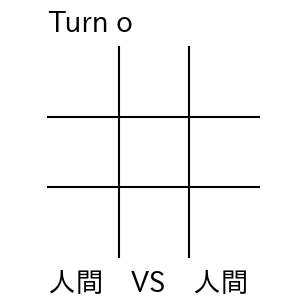

In [16]:
gui_play()

In [17]:
import pickle

with open("test.pkl", "wb") as f:
    pickle.dump([1, 2, 3], f) 

In [18]:
with open("test.pkl", "rb") as f:
    print(pickle.load(f)) 

[1, 2, 3]


In [19]:
def create_widgets(self):
    # 乱数の種の Checkbox と IntText を作成する
    self.checkbox = widgets.Checkbox(value=self.seed is not None, description="乱数の種",
                                     indent=False, layout=widgets.Layout(width="100px"))
    self.inttext = widgets.IntText(value=0 if self.seed is None else self.seed,
                                   layout=widgets.Layout(width="100px"))   

    # 読み書きのボタンを作成する
    self.load_button = self.create_button("開く", 100)
    self.save_button = self.create_button("保存", 100)
    
    # AI を選択する Dropdown を作成する
    self.create_dropdown()
    # 変更、リセット、待ったボタンを作成する
    self.change_button = self.create_button("変更", 50)
    self.reset_button = self.create_button("リセット", 80)
    self.undo_button = self.create_button("待った", 60)    
    
    # リプレイのボタンとスライダーを作成する
    self.first_button = self.create_button("<<", 50)
    self.prev_button = self.create_button("<", 50)
    self.next_button = self.create_button(">", 50)
    self.last_button = self.create_button(">>", 50)     
    self.slider = widgets.IntSlider(layout=widgets.Layout(width="200px"))
    # ゲーム盤の画像を表す figure を作成する
    self.create_figure()       
    
Marubatsu_GUI.create_widgets = create_widgets

In [20]:
def display_widgets(self):
    # 乱数の種のウィジェット、読み書きのボタンを横に配置した HBox を作成する
    hbox1 = widgets.HBox([self.checkbox, self.inttext, self.load_button, self.save_button])
    # 〇 と × の dropdown とボタンを横に配置した HBox を作成する
    hbox2 = widgets.HBox([self.dropdown_list[0], self.dropdown_list[1], self.change_button, self.reset_button, self.undo_button])
    # リプレイ機能のボタンを横に配置した HBox を作成する
    hbox3 = widgets.HBox([self.first_button, self.prev_button, self.next_button, self.last_button, self.slider]) 
    # hbox1 ~ hbox3 を縦に配置した VBox を作成し、表示する
    display(widgets.VBox([hbox1, hbox2, hbox3])) 
    
Marubatsu_GUI.display_widgets = display_widgets

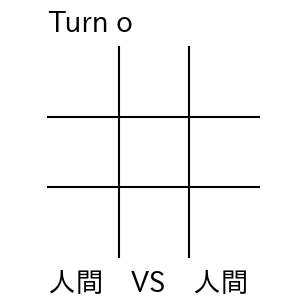

In [21]:
gui_play()

In [22]:
from tkinter import Tk, filedialog

root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

print(filedialog.askopenfilename())

C:/Users/ys/ai/marubatsu/086/marubatsu.ipynb


In [23]:
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

print(filedialog.asksaveasfilename())

C:/Users/ys/ai/marubatsu/086/test.pkl


In [24]:
import math

def create_event_handler(self):
    # 乱数の種のチェックボックスのイベントハンドラを定義する
    def on_checkbox_changed(changed):
        self.update_widgets_status()
        
    self.checkbox.observe(on_checkbox_changed, names="value")

    # 開く、保存ボタンのイベントハンドラを定義する
    def on_load_button_clicked(b):
        root = Tk()
        root.withdraw()
        root.call('wm', 'attributes', '.', '-topmost', True)        
        path = filedialog.askopenfilename()
        if path != "":
            with open(path, "rb") as f:
                data = pickle.load(f)
                self.mb.records = data["records"]
                self.mb.ai = data["ai"]
                change_step(data["move_count"])
 
    def on_save_button_clicked(b):
        root = Tk()
        root.withdraw()
        root.call('wm', 'attributes', '.', '-topmost', True)        
        path = filedialog.asksaveasfilename()
        if path != "":
            with open(path, "wb") as f:
                data = {
                    "records": self.mb.records,
                    "move_count": self.mb.move_count,
                    "ai": self.mb.ai,
                }
                pickle.dump(data, f)
            
    self.load_button.on_click(on_load_button_clicked)
    self.save_button.on_click(on_save_button_clicked)
    
    # 変更ボタンのイベントハンドラを定義する
    def on_change_button_clicked(b):
        for i in range(2):
            self.mb.ai[i] = None if self.dropdown_list[i].value == "人間" else self.dropdown_list[i].value
        self.mb.play_loop(self)

    # リセットボタンのイベントハンドラを定義する
    def on_reset_button_clicked(b=None):
        # 乱数の種のチェックボックスが ON の場合に、乱数の種の処理を行う
        if self.checkbox.value:
            random.seed(self.inttext.value)
        self.mb.restart()
        on_change_button_clicked(b)

    # 待ったボタンのイベントハンドラを定義する
    def on_undo_button_clicked(b=None):
        if self.mb.move_count >= 2 and self.mb.move_count == len(self.mb.records) - 1:
            self.mb.move_count -= 2
            self.mb.records = self.mb.records[0:self.mb.move_count+1]
            self.mb.change_step(self.mb.move_count)
            self.draw_board()
        
    # イベントハンドラをボタンに結びつける
    self.change_button.on_click(on_change_button_clicked)
    self.reset_button.on_click(on_reset_button_clicked)   
    self.undo_button.on_click(on_undo_button_clicked)   
    
    # step 手目の局面に移動する
    def change_step(step):
        self.mb.change_step(step)
        # 描画を更新する
        self.draw_board()        

    def on_first_button_clicked(b=None):
        change_step(0)

    def on_prev_button_clicked(b=None):
        change_step(self.mb.move_count - 1)

    def on_next_button_clicked(b=None):
        change_step(self.mb.move_count + 1)
        
    def on_last_button_clicked(b=None):
        change_step(len(self.mb.records) - 1)

    def on_slider_changed(changed):
        if self.mb.move_count != changed["new"]:
            change_step(changed["new"])
            
    self.first_button.on_click(on_first_button_clicked)
    self.prev_button.on_click(on_prev_button_clicked)
    self.next_button.on_click(on_next_button_clicked)
    self.last_button.on_click(on_last_button_clicked)
    self.slider.observe(on_slider_changed, names="value")
    
    # ゲーム盤の上でマウスを押した場合のイベントハンドラ
    def on_mouse_down(event):
        # Axes の上でマウスを押していた場合のみ処理を行う
        if event.inaxes and self.mb.status == Marubatsu.PLAYING:
            x = math.floor(event.xdata)
            y = math.floor(event.ydata)
            self.mb.move(x, y)                
            # 次の手番の処理を行うメソッドを呼び出す
            self.mb.play_loop(self)

    # ゲーム盤を選択した状態でキーを押した場合のイベントハンドラ
    def on_key_press(event):
        keymap = {
            "up": on_first_button_clicked,
            "left": on_prev_button_clicked,
            "right": on_next_button_clicked,
            "down": on_last_button_clicked,
            "0": on_undo_button_clicked,
            "enter": on_reset_button_clicked,            
        }
        if event.key in keymap:
            keymap[event.key]()
        else:
            try:
                num = int(event.key) - 1
                event.inaxes = True
                event.xdata = num % 3
                event.ydata = 2 - (num // 3)
                on_mouse_down(event)
            except:
                pass
            
    # fig の画像イベントハンドラを結び付ける
    self.fig.canvas.mpl_connect("button_press_event", on_mouse_down)     
    self.fig.canvas.mpl_connect("key_press_event", on_key_press)  
    
Marubatsu_GUI.create_event_handler = create_event_handler

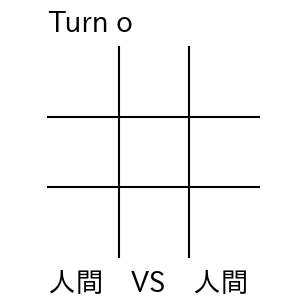

In [26]:
gui_play()